# US Agriculture Analysis
In this Jupyter notebook, I walk through my process for analyzing 2017 census data on U.S. agriculture.

The data for this analysis can be accessed on [USDA's website](https://www.nass.usda.gov/Publications/AgCensus/2017/index.php). 

![USDA-logo.png](media/USDA-Logo.png)

Retrieving the data in a format that is conducive to the type of ad hoc analysis that I wanted to perform turned out to be a bit challenging. USDA's website provides a nice "query tool" that allows users to perform basic filtering of data, but data export options are a bit limited. In the end the best option was to download the full dataset as a very large (over 1GB) tab-deliminated text file.

Working with large data files in-memory can be challenging so I decided to upload the dataset into a postgres database using [bit.io](https://bit.io/). 

![USDA-logo.png](media/bit-io-icon.png)

This allows me to query the data using SQL and load the necessary portions of the data into dataframes, as opposed loading the full, 1.6 GB file into a dataframe right from the start.

### Pulling the data
Below we can run a quick query against the bit.io hosted Postgres table to give us a sense of the data.

In [ ]:


df_1 = _deepnote_execute_sql("""-- previewing the first few rows of the data
SELECT * 
FROM "paytondhubbard/census_data"."2017_agg_census_data"
LIMIT 5
""", 'SQL_A566B8B6_80EA_40C4_ADA5_F5548D01A4B8')
df_1

,census_chapter,census_table,census_row,census_column,sector_desc,short_desc,commodity_desc,agg_level_desc,state_fips_code,state_alpha,state_name,county_code,county_name,domaincat_desc,value
0,1,72,191,5,ECONOMICS,"FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE",FUELS,STATE,15,HI,HAWAII,None,None,"FARM SALES: (100,000 TO 249,999 $) AND EXPENSE...",1
1,1,72,191,5,ECONOMICS,"FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE",FUELS,STATE,16,ID,IDAHO,None,None,"FARM SALES: (100,000 TO 249,999 $) AND EXPENSE...",37
2,1,72,191,5,ECONOMICS,"FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE",FUELS,STATE,17,IL,ILLINOIS,None,None,"FARM SALES: (100,000 TO 249,999 $) AND EXPENSE...",55
3,1,72,191,5,ECONOMICS,"FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE",FUELS,STATE,18,IN,INDIANA,None,None,"FARM SALES: (100,000 TO 249,999 $) AND EXPENSE...",24
4,1,72,191,5,ECONOMICS,"FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE",FUELS,STATE,19,IA,IOWA,None,None,"FARM SALES: (100,000 TO 249,999 $) AND EXPENSE...",38


The first table within the dataset has helpful, high-level statistics on farming on a state by state level. I'll filter the total dataset down to only the first table of census chapter 1 and save that table to `table_1_df_raw`

In [ ]:


table_1_df_raw = _deepnote_execute_sql("""SELECT *
FROM "paytondhubbard/census_data"."2017_agg_census_data"
WHERE census_chapter = 1
AND census_table = 1
""", 'SQL_A566B8B6_80EA_40C4_ADA5_F5548D01A4B8')
table_1_df_raw

,census_chapter,census_table,census_row,census_column,sector_desc,short_desc,commodity_desc,agg_level_desc,state_fips_code,state_alpha,state_name,county_code,county_name,domaincat_desc,value
0,1,1,2,1,ECONOMICS,FARM OPERATIONS - ACRES OPERATED,FARM OPERATIONS,STATE,48,TX,TEXAS,None,None,None,"127,036,184"
1,1,1,1,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,53,WA,WASHINGTON,None,None,None,"35,793"
2,1,1,1,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,54,WV,WEST VIRGINIA,None,None,None,"23,622"
3,1,1,1,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,55,WI,WISCONSIN,None,None,None,"64,793"
4,1,1,1,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,56,WY,WYOMING,None,None,None,"11,938"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,1,1,13,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,51,VA,VIRGINIA,None,None,"AREA OPERATED: (1,000 TO 1,999 ACRES)",966
5504,1,1,13,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,53,WA,WASHINGTON,None,None,"AREA OPERATED: (1,000 TO 1,999 ACRES)",996
5505,1,1,13,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,54,WV,WEST VIRGINIA,None,None,"AREA OPERATED: (1,000 TO 1,999 ACRES)",272
5506,1,1,13,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,55,WI,WISCONSIN,None,None,"AREA OPERATED: (1,000 TO 1,999 ACRES)","1,619"


Tables 46 and 47 contain information on the gender of the farmers themselves that I will save into `farmer_gender_table_df_raw`.

In [ ]:


farmer_gender_table_df_raw = _deepnote_execute_sql("""SELECT *
FROM "paytondhubbard/census_data"."2017_agg_census_data"
WHERE census_chapter = 2
AND census_table IN (46, 47)
AND agg_level_desc = 'STATE'
""", 'SQL_A566B8B6_80EA_40C4_ADA5_F5548D01A4B8')
farmer_gender_table_df_raw

,census_chapter,census_table,census_row,census_column,sector_desc,short_desc,commodity_desc,agg_level_desc,state_fips_code,state_alpha,state_name,county_code,county_name,domaincat_desc,value
0,2,47,1,3,DEMOGRAPHICS,"PRODUCERS, FEMALE - ACRES OPERATED",PRODUCERS,STATE,13,GA,GEORGIA,None,None,None,"3,631,877"
1,2,46,1,1,DEMOGRAPHICS,"PRODUCERS, MALE - NUMBER OF OPERATIONS",PRODUCERS,STATE,39,OH,OHIO,None,None,None,"72,398"
2,2,47,1,3,DEMOGRAPHICS,"PRODUCERS, FEMALE - ACRES OPERATED",PRODUCERS,STATE,9,CT,CONNECTICUT,None,None,None,"213,985"
3,2,47,1,3,DEMOGRAPHICS,"PRODUCERS, FEMALE - ACRES OPERATED",PRODUCERS,STATE,12,FL,FLORIDA,None,None,None,"3,615,319"
4,2,46,1,1,DEMOGRAPHICS,"PRODUCERS, MALE - NUMBER OF OPERATIONS",PRODUCERS,STATE,40,OK,OKLAHOMA,None,None,None,"72,234"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2,47,1,1,DEMOGRAPHICS,"PRODUCERS, FEMALE - NUMBER OF OPERATIONS",PRODUCERS,STATE,12,FL,FLORIDA,None,None,None,"29,779"
596,2,47,1,1,DEMOGRAPHICS,"PRODUCERS, FEMALE - NUMBER OF OPERATIONS",PRODUCERS,STATE,13,GA,GEORGIA,None,None,None,"21,570"
597,2,47,1,1,DEMOGRAPHICS,"PRODUCERS, FEMALE - NUMBER OF OPERATIONS",PRODUCERS,STATE,15,HI,HAWAII,None,None,None,"4,580"
598,2,47,1,1,DEMOGRAPHICS,"PRODUCERS, FEMALE - NUMBER OF OPERATIONS",PRODUCERS,STATE,16,ID,IDAHO,None,None,None,"16,134"


Tables 48 - 54 contain  information on the race of the farmers that I will save into `farmer_race_table_df_raw`.

In [ ]:


farmer_race_table_df_raw = _deepnote_execute_sql("""SELECT *
FROM "paytondhubbard/census_data"."2017_agg_census_data"
WHERE census_chapter = 2
AND census_table IN (48, 49, 50, 51, 52, 53, 54)
AND agg_level_desc = 'STATE'
""", 'SQL_A566B8B6_80EA_40C4_ADA5_F5548D01A4B8')
farmer_race_table_df_raw

,census_chapter,census_table,census_row,census_column,sector_desc,short_desc,commodity_desc,agg_level_desc,state_fips_code,state_alpha,state_name,county_code,county_name,domaincat_desc,value
0,2,48,1,1,DEMOGRAPHICS,"PRODUCERS, HISPANIC - NUMBER OF OPERATIONS",PRODUCERS,STATE,25,MA,MASSACHUSETTS,None,None,None,183
1,2,48,1,3,DEMOGRAPHICS,"PRODUCERS, HISPANIC - ACRES OPERATED",PRODUCERS,STATE,19,IA,IOWA,None,None,None,"244,591"
2,2,48,1,1,DEMOGRAPHICS,"PRODUCERS, HISPANIC - NUMBER OF OPERATIONS",PRODUCERS,STATE,1,AL,ALABAMA,None,None,None,477
3,2,48,1,1,DEMOGRAPHICS,"PRODUCERS, HISPANIC - NUMBER OF OPERATIONS",PRODUCERS,STATE,2,AK,ALASKA,None,None,None,36
4,2,48,1,1,DEMOGRAPHICS,"PRODUCERS, HISPANIC - NUMBER OF OPERATIONS",PRODUCERS,STATE,4,AZ,ARIZONA,None,None,None,"1,102"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2,54,1,3,DEMOGRAPHICS,"PRODUCERS, MULTI-RACE - ACRES OPERATED",PRODUCERS,STATE,15,HI,HAWAII,None,None,None,"240,407"
2102,2,54,1,3,DEMOGRAPHICS,"PRODUCERS, MULTI-RACE - ACRES OPERATED",PRODUCERS,STATE,16,ID,IDAHO,None,None,None,"49,689"
2103,2,54,1,3,DEMOGRAPHICS,"PRODUCERS, MULTI-RACE - ACRES OPERATED",PRODUCERS,STATE,17,IL,ILLINOIS,None,None,None,"71,930"
2104,2,54,1,3,DEMOGRAPHICS,"PRODUCERS, MULTI-RACE - ACRES OPERATED",PRODUCERS,STATE,18,IN,INDIANA,None,None,None,"26,231"


In [ ]:
table_1_df_raw.to_csv("data/table_1.csv", index=False)
farmer_gender_table_df_raw.to_csv("data/farmer_gender_table.csv", index=False)
farmer_race_table_df_raw.to_csv("data/farmer_race_table.csv", index=False)

To avoid having to re-query the original data every time I restart the notebook, I'll save off these tables into CSV files and immediately reload them.

This way, when re-starting the notebook, I can start in the section below without having to requery the original data.

### Data Cleaning
Before I can start analyzing our dataframe, I need to perform a bit of data cleaning work. Specifically, the `value` column has a data type of 'string' by default due to the presence of commas and other non-numeric characters in the raw data. I'll format this code as a function so that I can apply it to subsequent dataframes that I'll load in later in the process.

In [2]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
table_1_df_raw = pd.read_csv("data/table_1.csv")

In [4]:
def clean_data_frame(df):
    cleaned_df = df.copy()
    
    # Replace non numeric values with an empty string
    cleaned_df["value"] = cleaned_df["value"].str.replace(r"[^0-9]+", '', regex=True)
    
    # Coercing is necessary for the blank string values
    cleaned_df["value"] = pd.to_numeric(cleaned_df["value"], errors='coerce')
    
    # Convert from float to integer
    cleaned_df["value"] = cleaned_df["value"].fillna(0).astype(int)

    # Converting the state name to be sentence case
    cleaned_df["state_name"] = cleaned_df["state_name"].str.title()
    
    return cleaned_df

In [5]:
table_1_df = clean_data_frame(table_1_df_raw)

### Styling Functions
Below I add in a couple functions that will help to create U.S. map plots and nicely formatted table views.

In [6]:
def plot_map(df, state_col, intensity_col, title=False, cmap="Blues", legend=False):
    usa = gpd.read_file("./cb_2018_us_state_20m/cb_2018_us_state_20m.shp")
    
    # Filtering to have a simple continental map
    continental_us = usa.loc[~usa["NAME"].isin(["Alaska", "Hawaii", "Puerto Rico"])].copy()
    
    merged_df = continental_us.merge(df, how="left", left_on="NAME", right_on=state_col)
    merged_df.plot(column=intensity_col, cmap=cmap, legend=legend)
    plt.axis('off')
    if title:
        plt.title(title)
    return plt.show()

In [7]:
def style_dataframe(df, title=None, column_names=None, percent_column_indexes=None, 
                    highlighting=None, highlight_subset=None, heatmap=None, heatmap_subset=None):
    new_df = df.copy()
    percent_formatting = {}
    
    if column_names:
        column_conversions =  {old: new for old, new in zip(new_df.columns, column_names)}
        new_df.columns = column_names
        
    styler = new_df.style
    
    if title:
        styler.set_caption(title)
        
    if percent_column_indexes:
        percent_columns = new_df.columns[percent_column_indexes]
        styler.format({column_name: '{:,.2%}'.format for column_name in percent_columns})
        
    if highlighting:
        if highlight_subset:
            if column_names:
                subset_columns = [column_conversions[column_name] for column_name in highlight_subset]
            else:
                subset_columns = highlight_subset
            styler.highlight_max(color='#86BCE9', axis=1, subset=subset_columns)
        else:
            styler.highlight_max(color = '#86BCE9', axis = 1)
            
    if heatmap:
        if heatmap_subset:
            subset_columns = [column_conversions[column_name] for column_name in heatmap_subset]
            styler.background_gradient(cmap='Blues', axis=None, subset=subset_columns)
        else:
            styler.background_gradient(cmap='Blues', axis=None)
        
    return styler

In [8]:
def print_as_currency(value, postface=""):
    print("${:,}".format(value) + postface)

### Number of Farms per State
To start off our analysis, let's get an idea of how many farms are contained within each state.

In [9]:
# filter to only data pertaining to the number of farms in each state and only the columns we need
num_operations_filter = table_1_df["short_desc"] == "FARM OPERATIONS - NUMBER OF OPERATIONS"
num_farms_df = table_1_df.loc[num_operations_filter].copy()

Let's take a look at one state in particular to get a better idea of the data.

In [10]:
state_filter = num_farms_df["state_name"] == "Arkansas"
num_farms_ark_df = num_farms_df.loc[state_filter]
num_farms_ark_df

,census_chapter,census_table,census_row,census_column,sector_desc,short_desc,commodity_desc,agg_level_desc,state_fips_code,state_alpha,state_name,county_code,county_name,domaincat_desc,value
181,1,1,1,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,NaN,42625
280,1,1,8,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,AREA OPERATED: (1.0 TO 9.9 ACRES),2520
343,1,1,10,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,AREA OPERATED: (50 TO 179 ACRES),14838
354,1,1,11,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,AREA OPERATED: (180 TO 499 ACRES),8827
451,1,1,9,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,AREA OPERATED: (10.0 TO 49.9 ACRES),10404
569,1,1,12,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,AREA OPERATED: (500 TO 999 ACRES),2975
593,1,1,14,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,"AREA OPERATED: (2,000 OR MORE ACRES)",1464
1588,1,1,13,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,"AREA OPERATED: (1,000 TO 1,999 ACRES)",1597


As can be seen above, there is one row for Arkansas that doesn't include a `domaincat_desc` value. On first glance it looks like this could be a total row. Let's double check that assumption.

In [11]:
no_domaincat_desc = num_farms_ark_df["domaincat_desc"].isnull()
total_farms_w_domaincat_desc = num_farms_ark_df.loc[no_domaincat_desc, "value"].sum()
total_farms_no_domaincat_desc = num_farms_ark_df.loc[~no_domaincat_desc, "value"].sum()
print("Total number of farms that have a domaincat_desc value: " + str(total_farms_w_domaincat_desc))
print("Total number of farms that don't have a domaincat_desc value: " + str(total_farms_no_domaincat_desc))

Total number of farms that have a domaincat_desc value: 42625
Total number of farms that don't have a domaincat_desc value: 42625


Now that I've verified that the rows without a `domaincat_desc` value are total rows, I can filter on these rows to get a table of state totals.

In [12]:
only_totals_rows = num_farms_df["domaincat_desc"].isnull()
num_farms_totals = num_farms_df.loc[only_totals_rows, [ "state_name", "value"]].sort_values(["value"], ascending=False)
num_farms_totals = num_farms_totals.iloc[1:]
num_farms_totals.columns = ["State", "Number_of_Farms"]
num_farms_totals.reset_index(inplace=True, drop=True)

style_dataframe(
    num_farms_totals,
    title="Total # of Farms by State",
    column_names=["State", "Number of Farms"],
    heatmap=True
)

,State,Number of Farms
0,Texas,248416
1,Missouri,95320
2,Iowa,86104
3,Oklahoma,78531
4,Ohio,77805
5,Kentucky,75966
6,Illinois,72651
7,California,70521
8,Tennessee,69983
9,Minnesota,68822


Let's filter this down to just the top 5 states.

In [15]:
num_farms_totals["Percent_US_Total"] = (
    num_farms_totals["Number_of_Farms"] / num_farms_totals["Number_of_Farms"].sum()
)
top_five_states = num_farms_totals.iloc[0:5]

style_dataframe(
    top_five_states,
    title="Top 5 U.S. states - Number of Farms",
    column_names=["State", "Number of Farms", "Percent of U.S. Total"],
    percent_column_indexes=[2]
)

,State,Number of Farms,Percent of U.S. Total
0,Texas,248416,12.16%
1,Missouri,95320,4.67%
2,Iowa,86104,4.22%
3,Oklahoma,78531,3.85%
4,Ohio,77805,3.81%


In addition to viewing the state totals in a table, let's plot out the results in a map format.

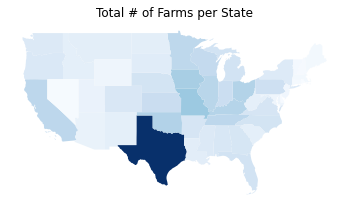

In [ ]:
plot_map(num_farms_totals, "State", "Number_of_Farms", title="Total # of Farms per State")

From this map and the previous table, we can see that Texas has far and away the most farms of any state in the U.S. with over 12% of the nation total.

One question that immediately comes to my mind though, is what this map would look like if we took a look at # of farms ***per capita***. This could really show us which states are "farm states" as opposed to states that just have a large population in general. 

In order to calculate a per capita figure, I'll pulll in census data on population estimates that can be found [here](https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/).

In [ ]:
# Reading in census data on population estimates
state_pop_df_raw = pd.read_excel(
    "https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/nst-est2019-01.xlsx"
)
rows_to_drop = [0 , 1, 2] + list(range(3,8)) + list(range(59, 66))

new_header_row = state_pop_df_raw.iloc[2].copy()
new_header_row[0] = "State"

state_pop_df = state_pop_df_raw.drop(rows_to_drop)
state_pop_df.columns = new_header_row
state_pop_df["State"] = state_pop_df["State"].str.replace(".", "", regex=True)
state_pop_df.reset_index(drop=True, inplace=True)

population_2017 = state_pop_df[["State", 2017]]
population_2017.columns = ["State",  "Population"]

# Previewing the first 5 rows of the df
population_2017.head()

,State,Population
0,Alabama,4874486.0
1,Alaska,739700.0
2,Arizona,7044008.0
3,Arkansas,3001345.0
4,California,39358497.0


Now we can merge this new population data with our `num_farms_totals` dataframe.

In [ ]:
farms_per_capita = num_farms_totals.merge(population_2017, how="left", left_on="State", right_on="State")
farms_per_capita["Farms_per_1000_people"] = farms_per_capita["Number_of_Farms"] / (farms_per_capita["Population"]/1000)
farms_per_capita.sort_values("Farms_per_1000_people", inplace=True, ascending=False)
farms_per_capita["Population"] = farms_per_capita["Population"].astype(int)
farms_per_capita.reset_index(drop=True, inplace=True)

style_dataframe(
    farms_per_capita,
    title="Number of Farms per capita by State",
    column_names=["State", "Number of Farms", "Percent of U.S. Total", "State Population", "Farms per 1000 people"],
    percent_column_indexes=[2],
    heatmap=True,
    heatmap_subset=["Farms_per_1000_people"]
)

,State,Number of Farms,Percent of U.S. Total,State Population,Farms per 1000 people
0,North Dakota,26364,1.29%,754942,34.921888
1,South Dakota,29968,1.47%,872868,34.332797
2,Iowa,86104,4.22%,3141550,27.408127
3,Montana,27048,1.32%,1052482,25.699252
4,Nebraska,46332,2.27%,1915947,24.182297
5,Wyoming,11938,0.58%,578931,20.620765
6,Kansas,58569,2.87%,2908718,20.135675
7,Oklahoma,78531,3.85%,3931316,19.975754
8,Kentucky,75966,3.72%,4452268,17.062315
9,Missouri,95320,4.67%,6106670,15.609162


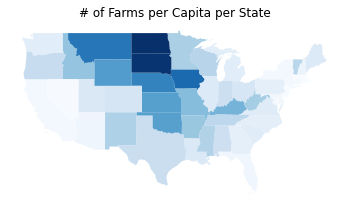

In [ ]:
plot_map(farms_per_capita, "State", "Farms_per_1000_people", title="# of Farms per Capita per State")

Looking at the data on a per-capita basis shows a different side of the story. While states like Montana, Wyoming, and the Dakotas don't have a large amount of farms on an absolute level, farm saturation is at higher levels than most other states.

It's interesting to note that **Iowa** is 3rd place on the absolute list of number of farms ***and*** 3rd place on the per-capita list.

### Farm size
Next I turn my attention to the geographic size of U.S. farms as measured in acres.

In [16]:
farm_size_conversions = {
    "AREA OPERATED: (500 TO 999 ACRES)": ["500-999", 5],
    "AREA OPERATED: (50 TO 179 ACRES)": ["50-179", 3],
    "AREA OPERATED: (180 TO 499 ACRES)": ["180-599", 4],
    "AREA OPERATED: (10.0 TO 49.9 ACRES)": ["10-49.9", 2],
    "AREA OPERATED: (1.0 TO 9.9 ACRES)": ["1-9.9", 1],
    "AREA OPERATED: (1,000 TO 1,999 ACRES)": ["1k-1,999", 6],
    "AREA OPERATED: (2,000 OR MORE ACRES)": ["2k+", 7],
}

In [17]:
farm_sizes_df = num_farms_df.loc[
    (num_farms_df["agg_level_desc"] == "NATIONAL") & 
    (~num_farms_df["domaincat_desc"].isnull()), 
    ["domaincat_desc", "value"]
    ].copy()

farm_sizes_df["farm_size_value"] = farm_sizes_df["domaincat_desc"].apply(lambda x: farm_size_conversions.get(x)[1])

farm_sizes_df = farm_sizes_df.sort_values("farm_size_value").reset_index(drop=True)
farm_sizes_df = farm_sizes_df.drop(columns=["farm_size_value"])
farm_sizes_df.columns = ["Farm_Size_Acres", "Number_of_Farms"]
farm_sizes_df["Farm_Size_Acres"] = farm_sizes_df["Farm_Size_Acres"].apply(lambda x: farm_size_conversions.get(x)[0])

style_dataframe(
    farm_sizes_df,
    title="Number of Farms by Size in Acres",
    column_names=["Farm Size in Acres", "Number of Farms"],
    heatmap=True
)

,Farm Size in Acres,Number of Farms
0,1-9.9,273325
1,10-49.9,583001
2,50-179,564763
3,180-599,315017
4,500-999,133321
5,"1k-1,999",87666
6,2k+,85127


Below we can see that most farms are between 10 - 179 acres in size.

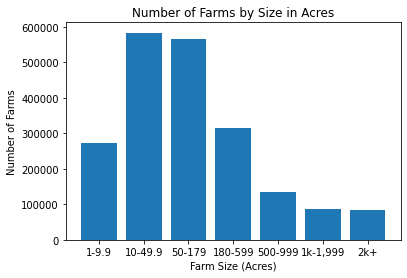

In [18]:
plt.bar(farm_sizes_df["Farm_Size_Acres"], farm_sizes_df["Number_of_Farms"])
plt.title("Number of Farms by Size in Acres")
plt.xlabel("Farm Size (Acres)")
plt.ylabel("Number of Farms")
plt.show()

Now let's take a look at which states are home to the very large, over 2k acre farms.

In [19]:
large_farms_filter = (
    (num_farms_df["domaincat_desc"] == "AREA OPERATED: (2,000 OR MORE ACRES)") & 
    (num_farms_df["agg_level_desc"] != "NATIONAL")
)
large_farms = num_farms_df.loc[large_farms_filter, ["short_desc", "state_name", "domaincat_desc", "value"]]
top_ten_states_large_farms = large_farms.groupby(["state_name"])["value"].sum().sort_values(ascending=False)[:10].reset_index()

style_dataframe(
    top_ten_states_large_farms,
    title="Number of farms with over 2k acres",
    column_names=["State", "Number of Farms >= 2k Acres"]
)

,State,Number of Farms >= 2k Acres
0,Texas,11037
1,North Dakota,6721
2,Kansas,6447
3,Montana,6338
4,South Dakota,5847
5,Nebraska,5472
6,Oklahoma,3637
7,Colorado,3614
8,New Mexico,2869
9,Illinois,2658


### Crops vs. Livestock
Now I'd like to take a look at which states are more livestock focused and which states are more crop focused. The `table 1` dataset includes information on total crop sales and total animal sales that we can use to answer this question.

In [20]:
# Filtering down to the data we need

desired_descriptions = ["CROP TOTALS - SALES, MEASURED IN $", "ANIMAL TOTALS, INCL PRODUCTS - SALES, MEASURED IN $"]

crops_livestock_filter = (
        (table_1_df["short_desc"].isin(desired_descriptions)) & 
        (table_1_df["state_name"] != "Us Total")
    )

crops_livestock_df = table_1_df.loc[
    crops_livestock_filter, ["commodity_desc", "state_name", "value"]
    ].copy()

crops_livestock_df = crops_livestock_df.pivot(index="state_name", columns="commodity_desc", values="value")
crops_livestock_df = crops_livestock_df.reset_index()
crops_livestock_df.columns = ["State_Name", "Livestock_Revenue", "Crop_Revenue"]
crops_livestock_df.head()

,State_Name,Livestock_Revenue,Crop_Revenue
0,Alabama,4768266000,1212329000
1,Alaska,40817000,29642000
2,Arizona,1757790000,2094218000
3,Arkansas,6026230000,3624930000
4,California,11800525000,33353834000


Now that we can see each state's livestock and crop revenue, I classify each state's dominant industry based on whether they have more revenue coming from livestock or crops.

In [21]:
crops_livestock_df["Dominant_Industry"] = np.where(
    crops_livestock_df["Livestock_Revenue"] >  crops_livestock_df["Crop_Revenue"], 
    "Livestock", "Crops"
    )

Below we can see that 28 out of 50 states earn more revenue from livestock than crops.

In [ ]:
style_dataframe(
    crops_livestock_df,
    title="Livestock vs. Crop Revenue by State",
    column_names=["State", "Revenue from Livestock", "Revenue from Crops", "Dominant Industry"]
)

,State,Revenue from Livestock,Revenue from Crops,Dominant Industry
0,Alabama,4768266000,1212329000,Livestock
1,Alaska,40817000,29642000,Livestock
2,Arizona,1757790000,2094218000,Crops
3,Arkansas,6026230000,3624930000,Livestock
4,California,11800525000,33353834000,Crops
5,Colorado,5252840000,2238862000,Livestock
6,Connecticut,160071000,420043000,Crops
7,Delaware,1140317000,325656000,Livestock
8,Florida,1652810000,5704533000,Crops
9,Georgia,6301312000,3271940000,Livestock


In [ ]:
total_livestock_revenue = crops_livestock_df["Livestock_Revenue"].sum()
total_crop_revenue = crops_livestock_df["Crop_Revenue"].sum()

print_as_currency(total_livestock_revenue, postface=" - US Total Livestock Revenue")
print_as_currency(total_crop_revenue, postface=" - US Total Crop Revenue")

$194,975,996,000 - US Total Livestock Revenue
$193,546,701,000 - US Total Crop Revenue


As can be seen above, U.S. revenue totals for livestock and crops are very similar, with livestock only bringing in about 1.4 billion more in revenue in 2017.

Below I map out which states earn more revenue from livestock and which earn more from crops

In [ ]:
import matplotlib.colors
my_cmap = matplotlib.colors.ListedColormap(['#4670AA', '#D9A979'])

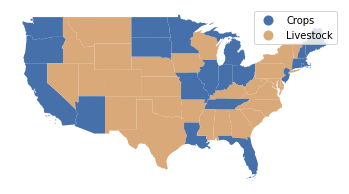

In [ ]:
plot_map(crops_livestock_df, "State_Name", "Dominant_Industry", cmap=my_cmap, legend=True)

### Focusing in on livestock
Distinguishing between crop farming and livestock farming is helpful, but livestock is still a very large category that includes:
- Beef cows
- Milk cows
- Hogs
- Chickens

By diving into these details, I can further parse out the dominant type of livestock that each state produces.

I can look at either the total inventory of each animal type by state, or the total number of farms that have inventory of each animal by state. In this case, I'll look at the total number of farms that carry inventory of each animal.


In [ ]:
# filtering to only livestock and previewing the first 5 rows

desired_descriptions = [
    "CATTLE, COWS, BEEF - OPERATIONS WITH INVENTORY", 
    "CATTLE, COWS, MILK - OPERATIONS WITH INVENTORY",
    "HOGS - OPERATIONS WITH INVENTORY",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY"
    ]

livestock_details_filter = (
    (table_1_df["short_desc"].isin(desired_descriptions)) &
    (table_1_df["state_name"] != "Us Total")
    )

livestock_details_df_raw = table_1_df.loc[
    livestock_details_filter,
    ["short_desc", "state_name", "value"]
    ]
    
livestock_details_df_raw.head()

,short_desc,state_name,value
2047,"CATTLE, COWS, MILK - OPERATIONS WITH INVENTORY",Alabama,366
2048,"CATTLE, COWS, MILK - OPERATIONS WITH INVENTORY",Alaska,27
2049,"CATTLE, COWS, MILK - OPERATIONS WITH INVENTORY",Arizona,186
2050,"CATTLE, COWS, MILK - OPERATIONS WITH INVENTORY",Arkansas,72
2051,"CATTLE, COWS, MILK - OPERATIONS WITH INVENTORY",California,1653


In [ ]:
# Pivoting the data and calculating percentages

livestock_details_df = livestock_details_df_raw.pivot(index="state_name", columns="short_desc", values="value")
livestock_percentages = livestock_details_df.div(livestock_details_df.sum(axis=1), axis=0)

percentage_columns = ["Percent_Beef_Cow_Farms", "Percent_Milk_Cow_Farms", "Percent_Chicken_Farms", "Percent_Hog_Farms"]
livestock_percentages.columns = percentage_columns


livestock_details_df = livestock_details_df.join(livestock_percentages)

livestock_percentages = livestock_percentages.reset_index()
livestock_details_df = livestock_details_df.reset_index()

livestock_details_df.columns = [
    "State_Name", "Num_Beef_Cow_Farms", "Num_Milk_Cow_Farms", 
    "Num_Chicken_Farms", "Num_Hog_Farms"] + percentage_columns

style_dataframe(
    livestock_percentages,
    title="Livestock Percentages by State",
    column_names=["State", "% Beef Cow Farms", "% Milk Cow Farms", "% Chicken Farms", "% Hog Farms"],
    percent_column_indexes=[1,2,3,4],
    heatmap=True
)

,State,% Beef Cow Farms,% Milk Cow Farms,% Chicken Farms,% Hog Farms
0,Alabama,79.26%,1.45%,15.03%,4.26%
1,Alaska,24.73%,7.26%,50.81%,17.20%
2,Arizona,64.56%,2.16%,27.23%,6.05%
3,Arkansas,81.18%,0.25%,14.97%,3.60%
4,California,51.68%,8.33%,32.99%,7.00%
5,Colorado,61.62%,2.90%,29.40%,6.09%
6,Connecticut,33.90%,7.80%,49.86%,8.44%
7,Delaware,43.52%,9.26%,37.04%,10.19%
8,Florida,67.88%,2.20%,23.27%,6.64%
9,Georgia,69.89%,2.69%,22.29%,5.13%


As we can see from the table above, for most states, the majority of their livestock farms are focused on beef.

Below we can take a look at all states where beef cattle farms do not form the majority. Unsurprisingly, these states are primarily smaller, northeastern states that don't have much land area for beef cattle.

In [ ]:
non_beef_majority_filter = livestock_percentages["Percent_Beef_Cow_Farms"] <= 0.5
non_beef_majority = livestock_percentages.loc[non_beef_majority_filter]

style_dataframe(
    non_beef_majority,
    column_names=["State", "% Beef Cow Farms", "% Milk Cow Farms", "% Chicken Farms", "% Hog Farms"],
    heatmap=True,
    heatmap_subset=["Percent_Milk_Cow_Farms", "Percent_Chicken_Farms", "Percent_Hog_Farms"],
    percent_column_indexes=[1,2,3,4]
)

,State,% Beef Cow Farms,% Milk Cow Farms,% Chicken Farms,% Hog Farms
1,Alaska,24.73%,7.26%,50.81%,17.20%
6,Connecticut,33.90%,7.80%,49.86%,8.44%
7,Delaware,43.52%,9.26%,37.04%,10.19%
18,Maine,29.17%,11.50%,48.36%,10.97%
19,Maryland,44.65%,9.18%,36.08%,10.09%
20,Massachusetts,27.91%,6.99%,54.40%,10.70%
21,Michigan,39.90%,11.57%,37.72%,10.81%
28,New Hampshire,26.83%,9.63%,51.02%,12.52%
29,New Jersey,27.82%,3.22%,58.71%,10.26%
31,New York,37.66%,23.95%,29.43%,8.96%


Below we take a look at the 5 states with the most total farms and highest percentage of farms for each livestock type.

In [ ]:
livestock_types = ["Beef_Cow", "Milk_Cow", "Chicken", "Hog"]
top_5_states = {}

def print_top_five_states(column_prefix, print_postface):
    for livestock_type in livestock_types:
        column_name = column_prefix + "_" + livestock_type + "_Farms"
        states = livestock_details_df[
        ["State_Name", column_name]
        ].sort_values(column_name, ascending=False).iloc[:5].reset_index(drop=True)

        top_5_states[livestock_type] = states["State_Name"]

        title = "Top 5 " + livestock_type.replace('_', ' ') + " states " + print_postface
        display(style_dataframe(
                states, 
                title=title
            ))
        print("\n")

print_top_five_states("Num", "(Total # of Farms)")
print("---------------\n")
print_top_five_states("Percent", "(Percentage of Farms)")

,State_Name,Num_Beef_Cow_Farms
0,Texas,134250
1,Missouri,48122
2,Oklahoma,46080
3,Kentucky,33864
4,Tennessee,32960


,State_Name,Num_Milk_Cow_Farms
0,Wisconsin,9037
1,Pennsylvania,6914
2,New York,4648
3,Minnesota,3644
4,Ohio,3346


,State_Name,Num_Chicken_Farms
0,Texas,28096
1,Ohio,10274
2,Oklahoma,9894
3,Pennsylvania,9290
4,Missouri,9052


,State_Name,Num_Hog_Farms
0,Texas,5894
1,Iowa,5660
2,Ohio,3484
3,Minnesota,3225
4,Pennsylvania,2777




---------------



,State_Name,Percent_Beef_Cow_Farms
0,North Dakota,0.886559
1,South Dakota,0.822390
2,Arkansas,0.811756
3,Kansas,0.810167
4,Nebraska,0.799630


,State_Name,Percent_Milk_Cow_Farms
0,Wisconsin,0.272355
1,New York,0.239477
2,Pennsylvania,0.215008
3,Vermont,0.206178
4,Minnesota,0.143166


,State_Name,Percent_Chicken_Farms
0,New Jersey,0.587053
1,Massachusetts,0.543982
2,New Hampshire,0.510250
3,Alaska,0.508065
4,Rhode Island,0.500000


,State_Name,Percent_Hog_Farms
0,Iowa,0.183480
1,Alaska,0.172043
2,Minnesota,0.126704
3,Rhode Island,0.125523
4,New Hampshire,0.125223


Now let's map out the locations of the top 5 states (percentage wise) for each livestock category.

In [ ]:
livestock_details_df["top_five_beef_cow"] = livestock_details_df["State_Name"].isin(top_5_states["Beef_Cow"])

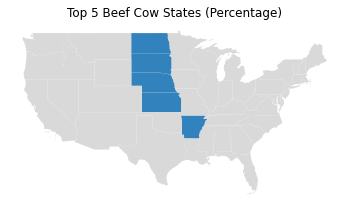

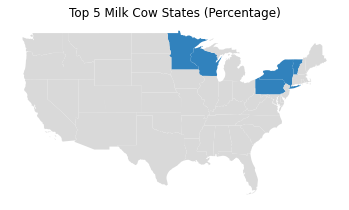

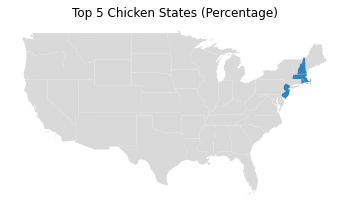

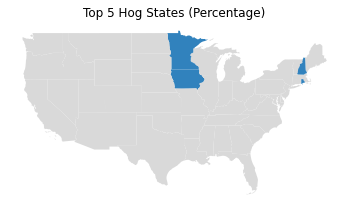

In [ ]:

for livestock_type in livestock_types:
    column_name = "top_five_" + livestock_type
    livestock_details_df[column_name] = ~livestock_details_df["State_Name"].isin(top_5_states[livestock_type])
    title = "Top 5 " + livestock_type.replace('_', ' ') + " States (Percentage)"
    plot_map(livestock_details_df, "State_Name", column_name, title=title, cmap="tab20c")

### Farmer Gender
Now I'll move into looking at farmer demographics, starting with gender. Here we will use demographic information on "principal producers". The USDA census defines "principal producers" as individuals who indicated that they are principal operators or senior partners on the farm in question.

In [ ]:
# Read in the data we had queried earlier and filter to only principal producer info

farmer_gender_df_raw = pd.read_csv("data/farmer_gender_table.csv")
farmer_gender_df = clean_data_frame(farmer_gender_df_raw)
producer_gender_filter = farmer_gender_df["short_desc"].isin(
    ["PRODUCERS, PRINCIPAL, MALE - NUMBER OF PRODUCERS", "PRODUCERS, PRINCIPAL, FEMALE - NUMBER OF PRODUCERS"]
    )

farmer_gender_df = farmer_gender_df.loc[producer_gender_filter, ["short_desc", "state_name", "value"]]
farmer_gender_df["gender"] = np.where(
    farmer_gender_df["short_desc"].str.contains("FEMALE"), 
    "Female", "Male"
    )

In [ ]:
national_gender_breakdown = pd.DataFrame(farmer_gender_df.groupby(["gender"])["value"].sum()).reset_index()
national_gender_breakdown["percentage"] = national_gender_breakdown["value"] / national_gender_breakdown["value"].sum()

style_dataframe(
    national_gender_breakdown,
    title="Gender of U.S. Farmers",
    column_names=["Gender", "Number of Farmers", "Percent of Farmers"],
    percent_column_indexes=[2]
)

,Gender,Number of Farmers,Percent of Farmers
0,Female,798500,29.14%
1,Male,1941953,70.86%


Here we can see that a bit over 70% of all principal farmer producers in the US are male. Let's take a look at which states have the largest proportion of female producers and which states are the most male-dominated.

In [ ]:
state_gender_breakdown = farmer_gender_df.pivot(index="state_name", columns="gender", values="value").reset_index()
state_gender_breakdown.index.name = None
state_gender_breakdown["percent_female"] = state_gender_breakdown["Female"]/(state_gender_breakdown["Female"] + state_gender_breakdown["Male"])

style_dataframe(
    state_gender_breakdown,
    title="Gender of U.S. Farmers by State",
    column_names=["State", "Number of Female Farmers", "Number of Male Farmers", "Percent of Farmers who are Female"],
    heatmap=True,
    heatmap_subset=["percent_female"],
    percent_column_indexes=[3]
)

,State,Number of Female Farmers,Number of Male Farmers,Percent of Farmers who are Female
0,Alabama,14393,38670,27.12%
1,Alaska,617,757,44.91%
2,Arizona,12122,13236,47.80%
3,Arkansas,17573,40773,30.12%
4,California,32155,66781,32.50%
5,Colorado,20405,35334,36.61%
6,Connecticut,2863,4729,37.71%
7,Delaware,924,2214,29.45%
8,Florida,23360,41095,36.24%
9,Georgia,15585,39840,28.12%


Below we can islote those states that have the highest proportion of female farming producers and those that have the lowest.

In [ ]:
top_five_female_states = state_gender_breakdown.sort_values("percent_female", ascending=False)
top_five_female_states = top_five_female_states.iloc[:5, [0, 3]].reset_index(drop=True)
style_dataframe(
    top_five_female_states,
    title="Top 5 States - % of Female Farmers",
    column_names=["State", "Percent of Farmers who are Female"],
    percent_column_indexes=[1]
)

,State,Percent of Farmers who are Female
0,Arizona,47.80%
1,Alaska,44.91%
2,New Hampshire,43.12%
3,Massachusetts,40.75%
4,Maine,39.84%


In [ ]:
bottom_five_female_states = state_gender_breakdown.sort_values("percent_female")
bottom_five_female_states = bottom_five_female_states.iloc[:5, [0, 3]].reset_index(drop=True)

style_dataframe(
    bottom_five_female_states,
    title="Bottom 5 States - % of Female Farmers",
    column_names=["State", "Percent of Farmers who are Female"],
    percent_column_indexes=[1]
)

,State,Percent of Farmers who are Female
0,Illinois,20.75%
1,Minnesota,21.18%
2,North Dakota,21.23%
3,South Dakota,21.30%
4,Nebraska,22.46%


### Farmer Race
Next up, let's take a look at farmer race. We'll take a look at the total number of principal producers for each race, starting on a national level.

In [ ]:
farmer_race_df_raw = pd.read_csv("data/farmer_race_table.csv")
farmer_race_df_raw = clean_data_frame(farmer_race_df_raw)

In [ ]:
# Here I just provide alternative, shorter column names

race_conversion = {
    "PRODUCERS, PRINCIPAL, HISPANIC - NUMBER OF PRODUCERS": "hispanic",
    "PRODUCERS, PRINCIPAL, AMERICAN INDIAN OR ALASKA NATIVE - NUMBER OF PRODUCERS": "am_indian_alaska_native",
    "PRODUCERS, PRINCIPAL, ASIAN - NUMBER OF PRODUCERS": "asian",
    "PRODUCERS, PRINCIPAL, BLACK OR AFRICAN AMERICAN - NUMBER OF PRODUCERS": "black",
    "PRODUCERS, PRINCIPAL, NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER - NUMBER OF PRODUCERS": "hawaiian_pacific_islander",
    "PRODUCERS, PRINCIPAL, WHITE - NUMBER OF PRODUCERS": "white",
    "PRODUCERS, PRINCIPAL, MULTI-RACE - NUMBER OF PRODUCERS": "multi_race"
}

In [ ]:
# Filtering down the dataframe to only the desired values

race_description_filter = (farmer_race_df_raw["short_desc"].isin(race_conversion.keys()))
farmer_race_df = farmer_race_df_raw.loc[
    race_description_filter, ["short_desc", "state_name", "value"]]
farmer_race_df["race"] = farmer_race_df["short_desc"].apply(lambda x: race_conversion[x])

As we can see below, while white people make up around [76%](https://www.census.gov/quickfacts/fact/table/US/PST045219) of the U.S. population, white farmers make up **92%** of all farmers in the United States.

In [ ]:
# Grouping the data on a national level

us_race_breakdown = farmer_race_df.groupby(["race"])["value"].sum().reset_index().sort_values("value", ascending=False)
us_race_breakdown.columns = ["race", "num_farmers"]
us_race_breakdown["percent_farmers"] =  round(us_race_breakdown["num_farmers"]/us_race_breakdown["num_farmers"].sum(), 2)

style_dataframe(
    us_race_breakdown, 
    column_names=["Race", "Number of Farmers", "Percent of all Farmers"], 
    title="U.S. Farmer Race Demographics:", 
    percent_column_indexes=[2]
)

,Race,Number of Farmers,Percent of all Farmers
6,white,2614526,92.00%
4,hispanic,90344,3.00%
0,am_indian_alaska_native,46210,2.00%
2,black,38447,1.00%
5,multi_race,21986,1.00%
1,asian,16978,1.00%
3,hawaiian_pacific_islander,2306,0.00%


Below we can take a look at this race breakdown on a state-by-state level. Arizona is the only state whose farmers aren't majority-white, with the American Indian/Alsaka Native race category accounting for over half of all farmers in the Grand Canyon state.

In [ ]:
state_race_breakdown_totals = farmer_race_df.groupby(["state_name", "race"])["value"].sum().reset_index().sort_values("value", ascending=False)
state_race_breakdown_totals = state_race_breakdown_totals.pivot(index="state_name", columns="race", values="value")

state_race_breakdown = state_race_breakdown_totals.div(state_race_breakdown_totals.sum(axis=1), axis=0)
state_race_breakdown.columns = [column_name + "_perc" for column_name in state_race_breakdown.columns]

state_race_breakdown = state_race_breakdown.sort_values("white_perc")
not_white_majority_filter = state_race_breakdown.idxmax(axis=1) != "white_perc"  # return the index of the maximum column for each row

style_dataframe(
    state_race_breakdown.loc[not_white_majority_filter],
    title="States where white farmers are not the majority",
    column_names=["American Indian/Alaska Native", "Asian", "Black", "Hawaiian/Pacific Islander", "Hispanic", "Multi-Racial", "White"],
    percent_column_indexes=[0,1,2,3,4,5,6],
    highlighting=True
)

,American Indian/Alaska Native,Asian,Black,Hawaiian/Pacific Islander,Hispanic,Multi-Racial,White
state_name,,,,,,,
Arizona,54.94%,0.42%,0.16%,0.22%,4.35%,0.68%,39.23%


Since Arizona is the only state without majority-white farmers, let's isolate the states who have white-farmer percentages < 90%. In the below table, we can see that 10 U.S. states fit this filter. I highlight the largest non-white ethnic percentage for each state.

In [ ]:
white_perc_filter = state_race_breakdown["white_perc"] < .9
state_race_breakdown_perc = state_race_breakdown.loc[white_perc_filter]


style_dataframe(
    state_race_breakdown_perc,
    title="States with white-farmer percentages less than 90%",
    column_names=["American Indian/Alaska Native", "Asian", "Black", "Hawaiian/Pacific Islander", "Hispanic", "Multi-Racial", "White"],
    percent_column_indexes=[0,1,2,3,4,5,6],
    highlighting=True,
    highlight_subset=["am_indian_alaska_native_perc", "asian_perc", "black_perc", "hawaiian_pacific_islander_perc", "hispanic_perc", "multi_race_perc"]
)

,American Indian/Alaska Native,Asian,Black,Hawaiian/Pacific Islander,Hispanic,Multi-Racial,White
state_name,,,,,,,
Arizona,54.94%,0.42%,0.16%,0.22%,4.35%,0.68%,39.23%
Hawaii,0.31%,25.27%,0.18%,8.44%,6.00%,10.25%,49.55%
New Mexico,16.03%,0.23%,0.12%,0.06%,23.44%,0.54%,59.58%
California,1.06%,4.79%,0.30%,0.31%,10.16%,1.25%,82.12%
Oklahoma,8.88%,0.36%,1.36%,0.04%,1.99%,4.11%,83.25%
Mississippi,0.27%,0.21%,12.95%,0.05%,1.03%,0.50%,84.99%
Florida,0.64%,1.56%,2.76%,0.12%,8.26%,0.83%,85.84%
Texas,0.65%,0.35%,2.59%,0.04%,9.11%,0.78%,86.49%
Nevada,4.71%,0.36%,0.18%,nan%,4.61%,0.99%,89.14%


### Conclusion
And that is the end of this first pass at analysis. I've taken a look at the number and size of farms in the United States, their primary products (livestock and crops), and a few demographic characteristics of U.S. farmers.

After all that, I've only scratched the surface of the census data set. While we've only partially analyzed 10 tables from the census in this notebook, there are 134 tables in the dataset that you can take a look at. Feel free to duplicate this notebook and continue the analysis on your own!

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=05802224-8515-4af2-8e4b-abb5e40d0066' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>